In [1]:
import pandas as pd
from glob import glob
import config
import utils
from importlib import reload
from os.path import join as j
import numpy as np
import json

reload(config)
reload(utils)

<module 'utils' from '/home/dauin_user/gattanasio/CTS/CTS/utils.py'>

# Classification

In [2]:
CLASSIFIERS = {str(c) for c in config.HPARAMS.keys()}
print(CLASSIFIERS)

DETERMINISTIC = {str(c) for c in config.DETERMINISTIC}
print(DETERMINISTIC)

NUM_CLASSES = {2, 3}

CRYPTO = {str(c) for c in config.Cryptocurrency}
print(CRYPTO)

CLASS_RESULTS = j("results", "classification")
TRADING_RESULTS = j("results", "trading")

{'KNN', 'RFC', 'GNB', 'LG', 'MNB', 'MLP', 'SVC'}
{'KNN', 'MNB', 'GNB'}
{'ETH', 'BTC', 'LTC'}


In [3]:
def process_classification_results(data, num_classes):
    d = {
        "F1_macro": data.loc["f1-score", "macro avg"],
        "F1_weighted": data.loc["f1-score", "weighted avg"],
        "Accuracy": data.loc["precision", "accuracy"],
    }
    
    if num_classes == 2:
        d["F1_O"] = data.loc["f1-score", "1"]
        d["Precision_O"] = data.loc["precision", "1"]
        d["Recall_O"] = data.loc["recall", "1"]
    else:
        d["F1_O"] = data.loc["f1-score", ["-1", "1"]].mean()
        d["Precision_O"] = data.loc["precision", ["-1", "1"]].mean()
        d["Recall_O"] = data.loc["recall", ["-1", "1"]].mean()
    
    return d

In [19]:
results = list()

# read and process deterministic models
for model in list(DETERMINISTIC) + ["HE"]:
    for n_class in NUM_CLASSES:
        for crypto in CRYPTO:
            filename = utils.get_filename(crypto, model, n_class, None)
            res = pd.read_csv(j(CLASS_RESULTS, filename), index_col="metric")
            d = process_classification_results(res, n_class)
            d["classifier"] = model
            d["n_class"] = n_class
            d["crypto"] = crypto
            results.append(d)
            
deterministic = pd.DataFrame(results)

results = list()

# read and process non-deterministic models: average across seeds (random initializations)
for model in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for n_class in NUM_CLASSES:
        for crypto in CRYPTO:
            for seed in range(10):
                filename = utils.get_filename(crypto, model, n_class, seed)
                
                if model == "LSTM":
                    res = pd.read_csv(j(CLASS_RESULTS, filename), index_col=0)
                    res.index.name = "metric"
                else:
                    res = pd.read_csv(j(CLASS_RESULTS, filename), index_col="metric")
                
                d = process_classification_results(res, n_class)
                d["classifier"] = model
                d["n_class"] = n_class
                d["crypto"] = crypto
                d["seed"] = seed
                results.append(d)
                
non_deterministic_mean = pd.DataFrame(results).groupby(["classifier", "n_class", "crypto"]).mean().drop("seed", axis=1).reset_index()
non_deterministic_std = pd.DataFrame(results).groupby(["classifier", "n_class", "crypto"]).std().drop("seed", axis=1).reset_index()

In [20]:
deterministic.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j("results", "classification", "comparison_det.csv"))

In [21]:
non_deterministic_mean.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j("results", "classification", "comparison_nondet_mean.csv"))

non_deterministic_std.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j("results", "classification", "comparison_nondet_std.csv"))

# Trading

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
sns.set_theme("notebook", style="white", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [9]:
EQUITIES_FOLDER = j("data", "portfolio_simulations_equity_trend")


In [10]:
n_class = 3

equities = list()
for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for seed in range(10):
        filename = utils.get_equity_filename(classifier, n_class, seed)
        df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
        df["seed"] = seed
        df["classifier"] = classifier
        equities.append(df)
        
for classifier in list(DETERMINISTIC) + ["HE"]:
    filename = utils.get_equity_filename(classifier, n_class, None)
    df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
    df["classifier"] = classifier
    equities.append(df)
        
equities = pd.concat(equities, axis=0)

<AxesSubplot:xlabel='Date', ylabel='Equity'>

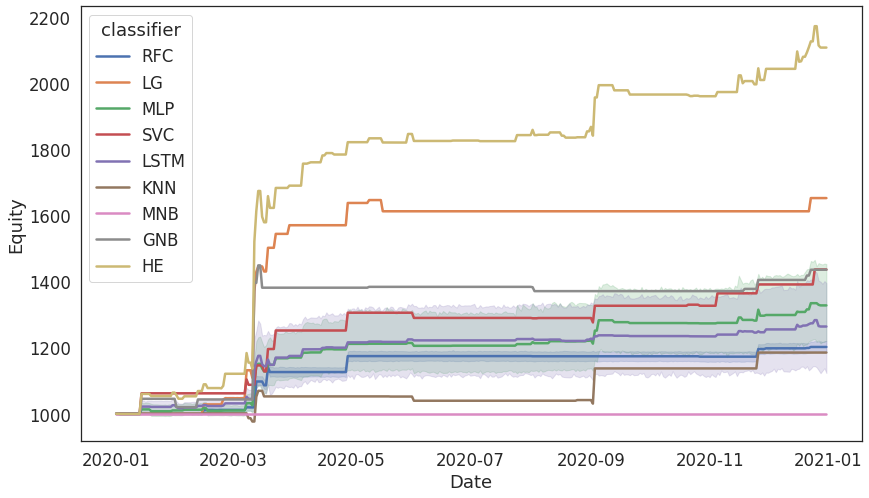

In [11]:
plt.figure(figsize=(14,8))
sns.lineplot(data=equities, x="Date", y="Equity", hue="classifier")

In [16]:
n_class = 2

equities = list()
for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for seed in range(10):
        filename = utils.get_equity_filename(classifier, n_class, seed)
        df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
        df["seed"] = seed
        df["classifier"] = classifier
        equities.append(df)
        
for classifier in list(DETERMINISTIC) + ["HE"]:
    filename = utils.get_equity_filename(classifier, n_class, None)
    df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
    df["classifier"] = classifier
    equities.append(df)
        
equities = pd.concat(equities, axis=0)

<AxesSubplot:xlabel='Date', ylabel='Equity'>

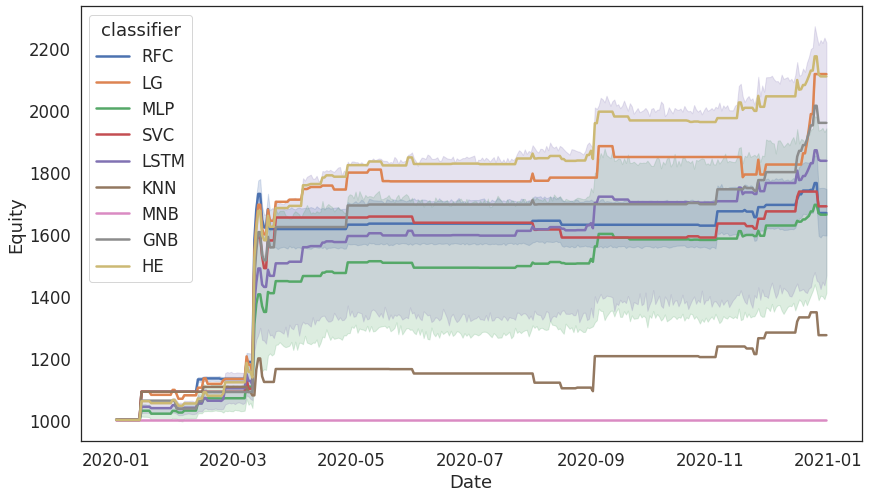

In [17]:
plt.figure(figsize=(14,8))
sns.lineplot(data=equities, x="Date", y="Equity", hue="classifier")

## Trading tables

In [14]:
RESULTS_DIR = j("results", "trading")

results = list()
for classifier in DETERMINISTIC:
    for n_class in NUM_CLASSES:
        filename = utils.get_trading_stats_filename(classifier, n_class, None)
        with open(j(RESULTS_DIR, filename)) as fp:
            d = json.load(fp)
            d["classifier"] = classifier
            d["n_class"] = n_class
            results.append(d)
        
results_det = pd.DataFrame(results).set_index("classifier").sort_values("n_class")

In [15]:
results_det

,long_pos,short_pos,total_pos,success_pos,success_perc,long_return,long_return_mean,long_return_std,short_return,short_return_mean,short_return_std,total_return,days,avg allocations,n_class
classifier,,,,,,,,,,,,,,,
KNN,16,16,32,19,59.375000,0.291557,0.018222,0.040577,0.216550,0.013534,0.038501,0.508107,348,0.459770,2
MNB,0,0,0,0,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,348,0.000000,2
GNB,31,16,47,36,76.595745,0.763463,0.024628,0.037091,1.187618,0.074226,0.132893,1.951081,348,0.606322,2
KNN,4,11,15,9,60.000000,0.141896,0.035474,0.049345,0.208941,0.018995,0.037888,0.350837,348,0.459770,3
MNB,0,0,0,0,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,348,0.000000,3
GNB,5,14,19,14,73.684211,0.121273,0.024255,0.044269,1.120970,0.080069,0.141104,1.242243,348,0.620690,3
